In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import shutil

os.chdir("../../test_data/system_tests/proteoforms/cluster_tests")

In [3]:
RESULTS = "results_minrep5"
COND1 = "egf_treated"
COND2 = "untreated"
CONDPAIR = (COND1, COND2)
SAMPLEMAP = "samplemap_egfr_100ng.tsv"

In [11]:
import alphaquant.utils.utils as aqutils
import alphaquant.cluster.cluster_utils as aqcluster_utils
import anytree
import copy

tree = aqutils.read_condpair_tree(cond1 = COND1, cond2 = COND2, results_folder = RESULTS)


protein = min(tree.children, key=lambda child: len(child.leaves))#with the least number of leaves


{'label_rotation': 0, 'add_stripplot': False, 'narrowing_factor_for_fcplot': 0.07142857142857142, 'rescale_factor_x': 1.0, 'rescale_factor_y': 1.0, 'pyteomics_fasta': None, 'parent_level': 'gene', '_order_peptides_along_protein_sequence': False, '_order_by_cluster': True}
protein
├── seq1
│   ├── mod_seq1a
│   └── mod_seq1b
├── seq2
│   ├── mod_seq2a
│   └── mod_seq2b
└── seq3
    ├── mod_seq3a
    └── mod_seq3b


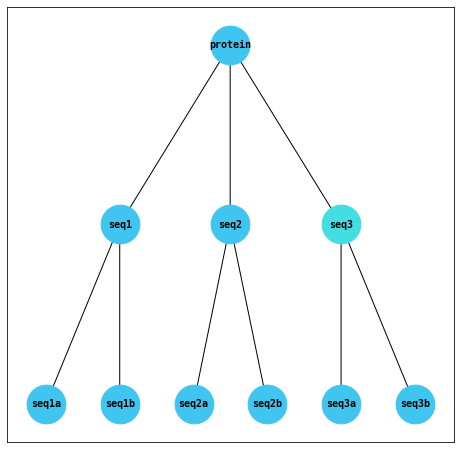

In [25]:
import alphaquant.viz.treeviz as aqtreeviz
import matplotlib.pyplot as plt

tp = aqtreeviz.TreePlotter(protein, parent_level = 'mod_seq_charge', label_rotation=0)
fig = tp.fig
ax = tp.ax
plt.show()


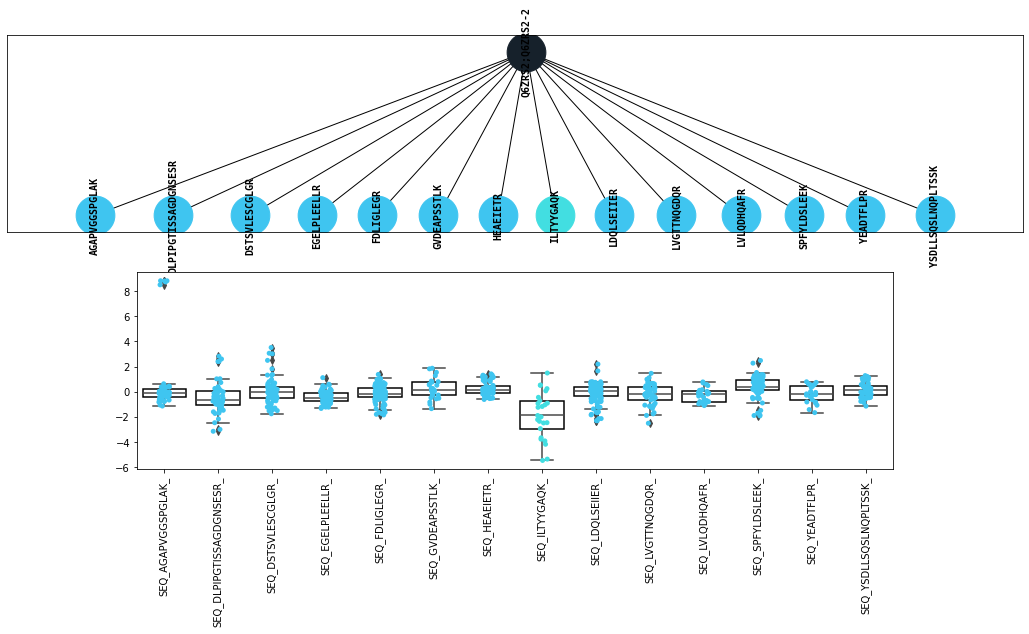

In [84]:
import alphaquant.viz.fcviz as aqfcviz

quantification_info = aqfcviz.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS, samplemap=SAMPLEMAP)
intensitydfgetter = aqfcviz.ProteinIntensityDataFrameGetter(quantification_info=quantification_info)

aqtreeviz.CombinedTreeAndFCPlotter(protein, parent_level = 'gene', condpair = CONDPAIR, intensitydfgetter = intensitydfgetter, add_stripplot = True, label_rotation=90)




In [80]:
import matplotlib.pyplot as plt
import networkx as nx
import anytree
import re
from matplotlib import gridspec
import matplotlib.pyplot as plt
import alphaquant.cluster.cluster_utils as aqcluster_utils
import alphaquant.viz.visualizations as aqviz



class TreePlotter():
    def __init__(self, protein, parent_level, fig = None, ax = None, label_rotation = 0):
        self.protein = protein

        self.fig = fig
        self.ax = ax

        self._parent_level = parent_level
        self._label_rotation = label_rotation
        
        self._shorten_protein_to_level()
        self._define_fig_and_ax()
        self._create_graph()
    
    def _define_fig_and_ax(self):
        if self.fig is None or self.ax is None:
            axis_creator = TreePlotAxisCreator(self.protein)
            axis_creator.define_tree_fig_and_ax()
            self.fig = axis_creator.fig
            self.ax = axis_creator.ax_tree

    def _shorten_protein_to_level(self):
        self.protein = aqcluster_utils.shorten_root_to_level(self.protein, self._parent_level)


    def _create_graph(self):
        GraphCreator(self.protein, self.ax, self._label_rotation)


class GraphCreator():
    
    def __init__(self, protein, ax, label_rotation = 0):
        self.graph = nx.DiGraph()
        self._protein = protein
        self._ax = ax
        self._label_rotation = label_rotation
        self._graph_parameters = GraphParameters()
        self._id2anytree_node = dict()
        self._colorlist = aqviz.AlphaPeptColorMap().colorlist_hex

        self._add_edges(protein)
        self._define_id2anytree_node()
        self._format_graph()
    
    def _add_edges(self, protein):
        children_sorted = sorted(protein.children, key=lambda x: x.name_reduced)
        for child in children_sorted:
            self.graph.add_edge(id(protein), id(child))
            self.graph.nodes[id(protein)]['label'] = protein.name_reduced
            self.graph.nodes[id(child)]['label'] = child.name_reduced
            self._add_edges(child)
        
    def _define_id2anytree_node(self):
        for node in anytree.PreOrderIter(self._protein):
            self._id2anytree_node[id(node)] = node

    def _format_graph(self):
        pos = nx.drawing.nx_agraph.graphviz_layout(self.graph, **self._graph_parameters.layout_params)

        for node in self.graph.nodes():
            matching_anynode  = self._id2anytree_node[node]
            is_included = matching_anynode.is_included
            if not is_included:
                self._graph_parameters.node_options["alpha"] = self._graph_parameters.alpha_excluded
            self._graph_parameters.node_options["node_color"] = self._determine_cluster_color(matching_anynode)
            nx.draw_networkx_nodes(self.graph, pos, nodelist=[node], ax=self._ax, **self._graph_parameters.node_options)

        label_dict = nx.get_node_attributes(self.graph, 'label')

        for node, (x, y) in pos.items():
            labelstring = label_dict[node]
            labelstring = TreeLabelFormatter.format_label_string(labelstring)
            self._ax.text(x, y, labelstring, verticalalignment='center', horizontalalignment='center', fontsize=10, family='monospace', weight = "bold", rotation = self._label_rotation)

        nx.draw_networkx_edges(self.graph, pos, ax=self._ax, **self._graph_parameters.edge_options)
    
    def _determine_cluster_color(self, anynode):
        return self._colorlist[anynode.cluster]


    
    @staticmethod
    def render_tree(root):
        for pre, _, node in anytree.RenderTree(root):
            print("%s%s" % (pre, node.name))


class GraphParameters():
    def __init__(self):
        self.included_color = "skyblue"
        self.excluded_color = "lightgrey"
        self.alpha_included = 1.0
        self.alpha_excluded = 0.2

        self.node_options = {
            "node_color": self.included_color,
            "node_size": 1500,
            "linewidths": 1,
            "alpha": self.alpha_included,  # default alpha
        }

        self.edge_options = {
            "edge_color": "black",
            "arrows": True,
        }

        self.label_options = {
            "font_size": 10,
            "font_color": "darkred",
            "font_weight": "bold",
        }
        self.layout_params = {
        "prog": "dot",
        "args": f"-Gnodesep={4.0/5} -Granksep={4.0/5}"
    }



class TreeLabelFormatter:
    @classmethod
    def format_label_string(cls, labelstring):
        labelstring = cls._cut_leading_type_classifier(labelstring)
        labelstring = cls._remove_leading_trailing_underscores(labelstring)
        labelstring = cls._replace_w_linebreaks(labelstring)
        return labelstring

    @staticmethod
    def _cut_leading_type_classifier(input_string):
        return re.sub(r'^[a-zA-Z0-9]+_', '', input_string)

    @staticmethod
    def _remove_leading_trailing_underscores(input_string):
        return input_string.strip('_')

    @staticmethod
    def _replace_w_linebreaks(input_string):
        result = input_string.replace('_', '\n')
        result = result.replace('[', '\n')
        result = result.replace(']', '\n')
        return result    


class TreePlotAxisCreator():

    def __init__(self, protein):
        self.fig = None
        self.ax_tree = None
        self.axes_fcs = None
        
        self._protein = protein

    def define_combined_tree_fc_fig_and_axes(self):
        parent2leaves = aqcluster_utils.get_parent2leaves_dict(self._protein)
        num_independent_plots = len(parent2leaves.keys())
        width_list = [len(x) for x in parent2leaves.values()]
        
        num_leaves = len(self._protein.leaves)
        max_depth = aqcluster_utils.find_max_depth(self._protein)
        
        fig_width = min(max(8, num_leaves * 1.3), 100)
        fig_height = max(8, max_depth * 4)
        
        self.fig = plt.figure(figsize=(fig_width, fig_height))
        
        small_width = fig_width/14  
        width_ratios = [small_width] + width_list + [small_width]
        
        gs = gridspec.GridSpec(2, num_independent_plots + 2, height_ratios=[1, 1], width_ratios=width_ratios)
        
        self.ax_tree = plt.subplot(gs[0, :])  
        
        ax_small_left = plt.subplot(gs[1, 0])
        ax_small_left.axis('off')
        
        ax_small_right = plt.subplot(gs[1, -1])
        ax_small_right.axis('off')
        
        self.axes_fcs = [plt.subplot(gs[1, i + 1]) for i in range(num_independent_plots)]  # Shifted to exclude the small subplots


    def define_tree_fig_and_ax(self):
        max_depth = aqcluster_utils.find_max_depth(self._protein)
        num_leaves = len(self._protein.leaves)
        fig_width = min(max(8, num_leaves * 1.3),100) 
        fig_height = max(8, max_depth * 2) 

        self.fig, self.ax_tree = plt.subplots(figsize=(fig_width, fig_height))





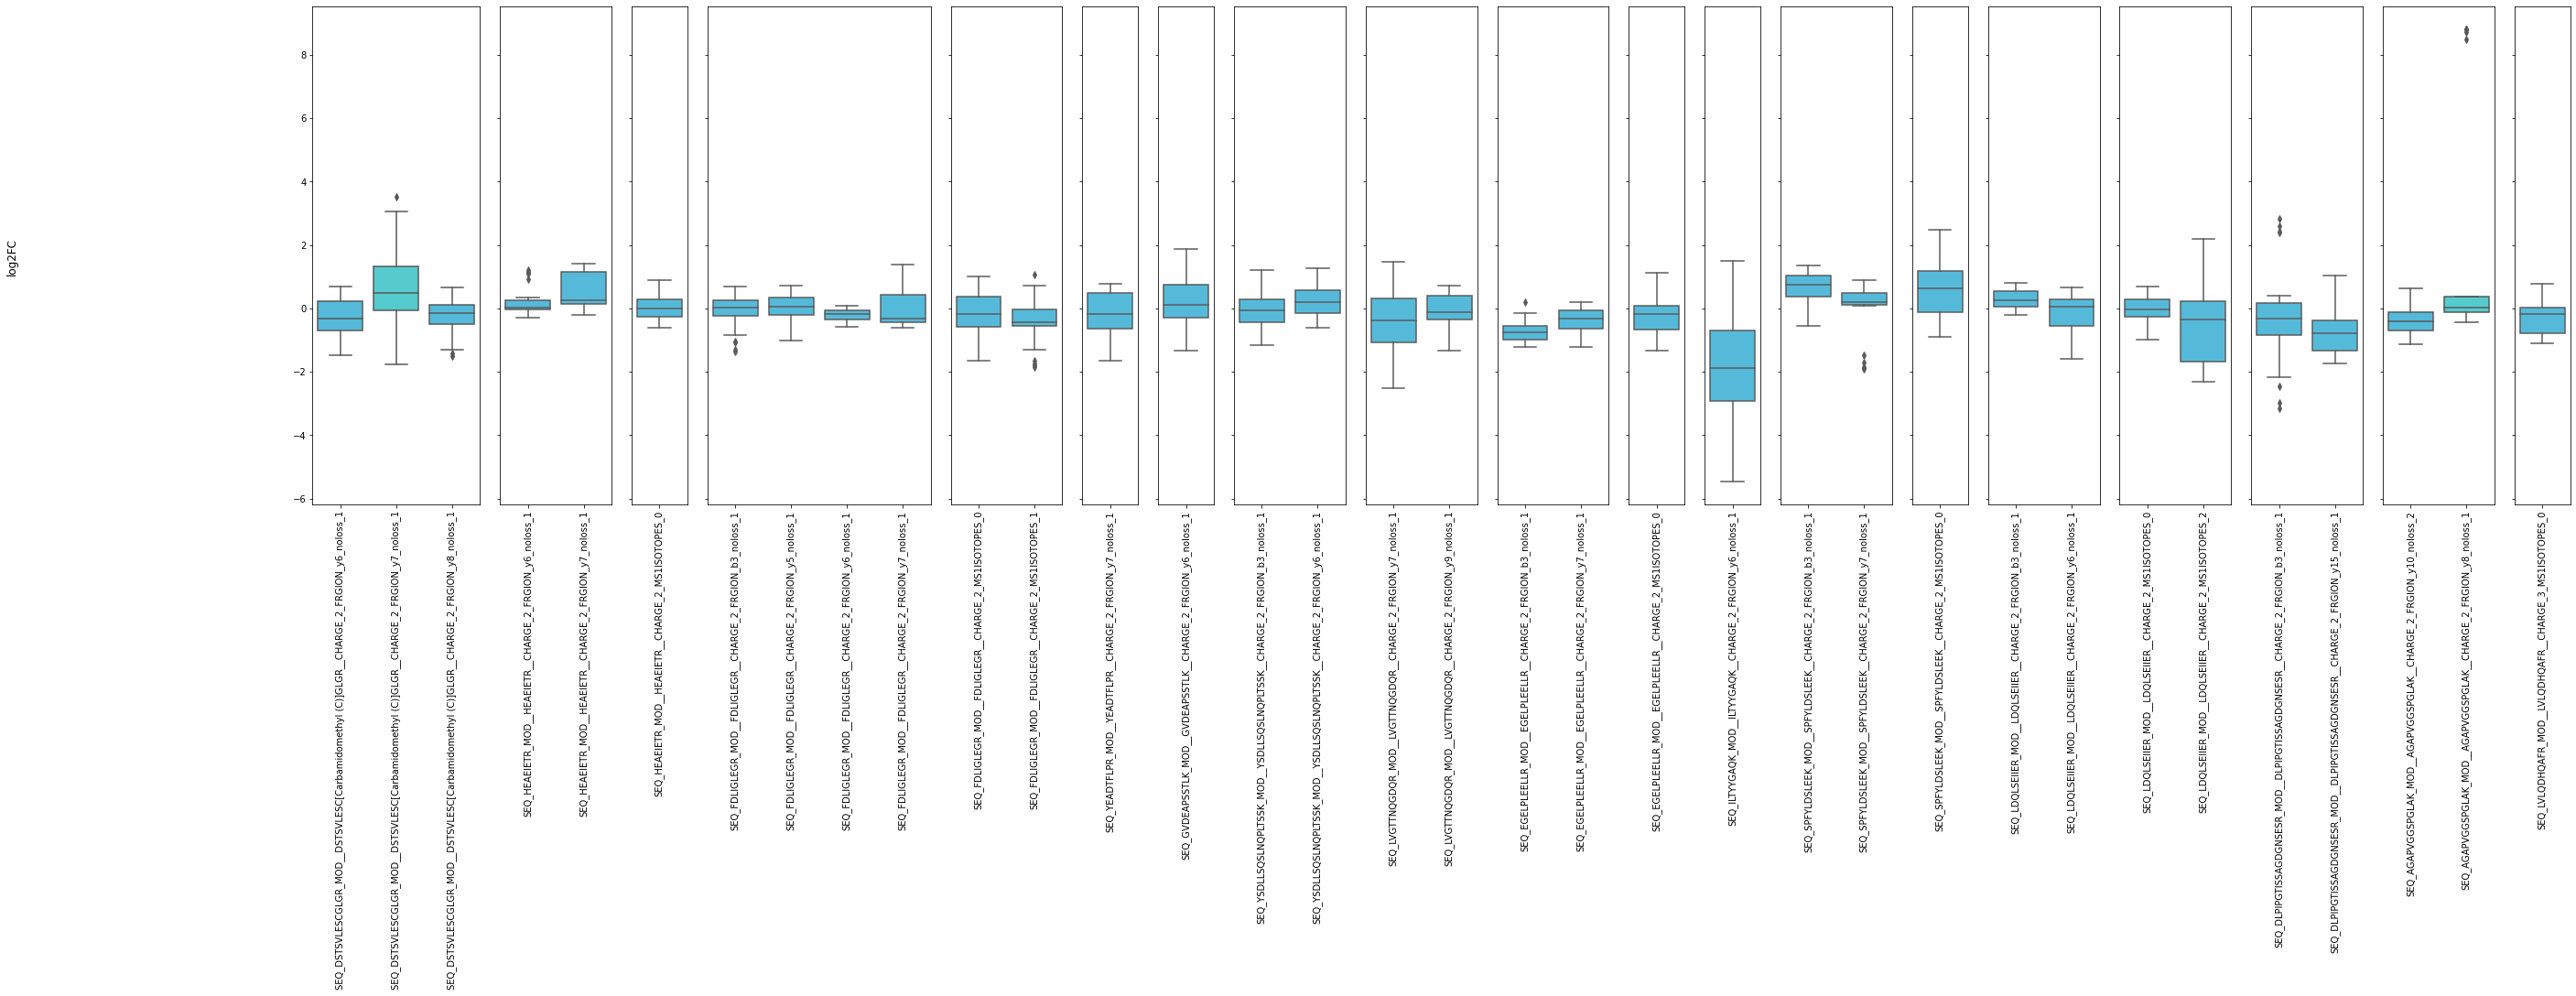

In [29]:
from anytree import Node, RenderTree

# Define a function for post-order traversal
def post_order_traversal(node):
    for child in node.children:
        post_order_traversal(child)
    if node.parent:
        node.reduced_name = node.name.replace(node.parent.name, "")

# Create a tree for demonstration
root = Node("root")
s0 = Node("root_s0", parent=root)
s1 = Node("root_s1", parent=root)
s00 = Node("root_s0_s00", parent=s0)
s01 = Node("root_s0_s01", parent=s0)

# Visualize the tree before performing the operation
for pre, _, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

# Perform the operation
post_order_traversal(root)

# Visualize the tree after performing the operation
print("\nAfter performing the operation:")
for pre, _, node in RenderTree(root):
    reduced_name = getattr(node, 'reduced_name', node.name)
    print("%s%s" % (pre, reduced_name))


root
├── root_s0
│   ├── root_s0_s00
│   └── root_s0_s01
└── root_s1

After performing the operation:
root
├── _s0
│   ├── _s00
│   └── _s01
└── _s1


In [ ]:
# Create your anytree object (replace 'Root', 'Child1', etc. with your actual node names)
root = Node("Root")

# Level 1
l1_1 = Node("L1_1", parent=root)
l1_2 = Node("L1_2", parent=root)

# Level 2
l2_1 = Node("L2_1", parent=l1_1)
l2_2 = Node("L2_2", parent=l1_1)

# Level 3
l3_1 = Node("L3_1", parent=l2_1)
l3_2 = Node("L3_2", parent=l2_1)
l3_3 = Node("L3_3", parent=l2_2)
l3_4 = Node("L3_4", parent=l2_2)

# Level 4
l4_1 = Node("L4_1", parent=l3_1)
l4_2 = Node("L4_2", parent=l3_1)
l4_3 = Node("L4_3", parent=l3_2)
l4_4 = Node("L4_4", parent=l3_2)
l4_5 = Node("L4_5", parent=l3_3)
l4_6 = Node("L4_6", parent=l3_3)
l4_7 = Node("L4_7", parent=l3_4)
l4_8 = Node("L4_8", parent=l3_4)

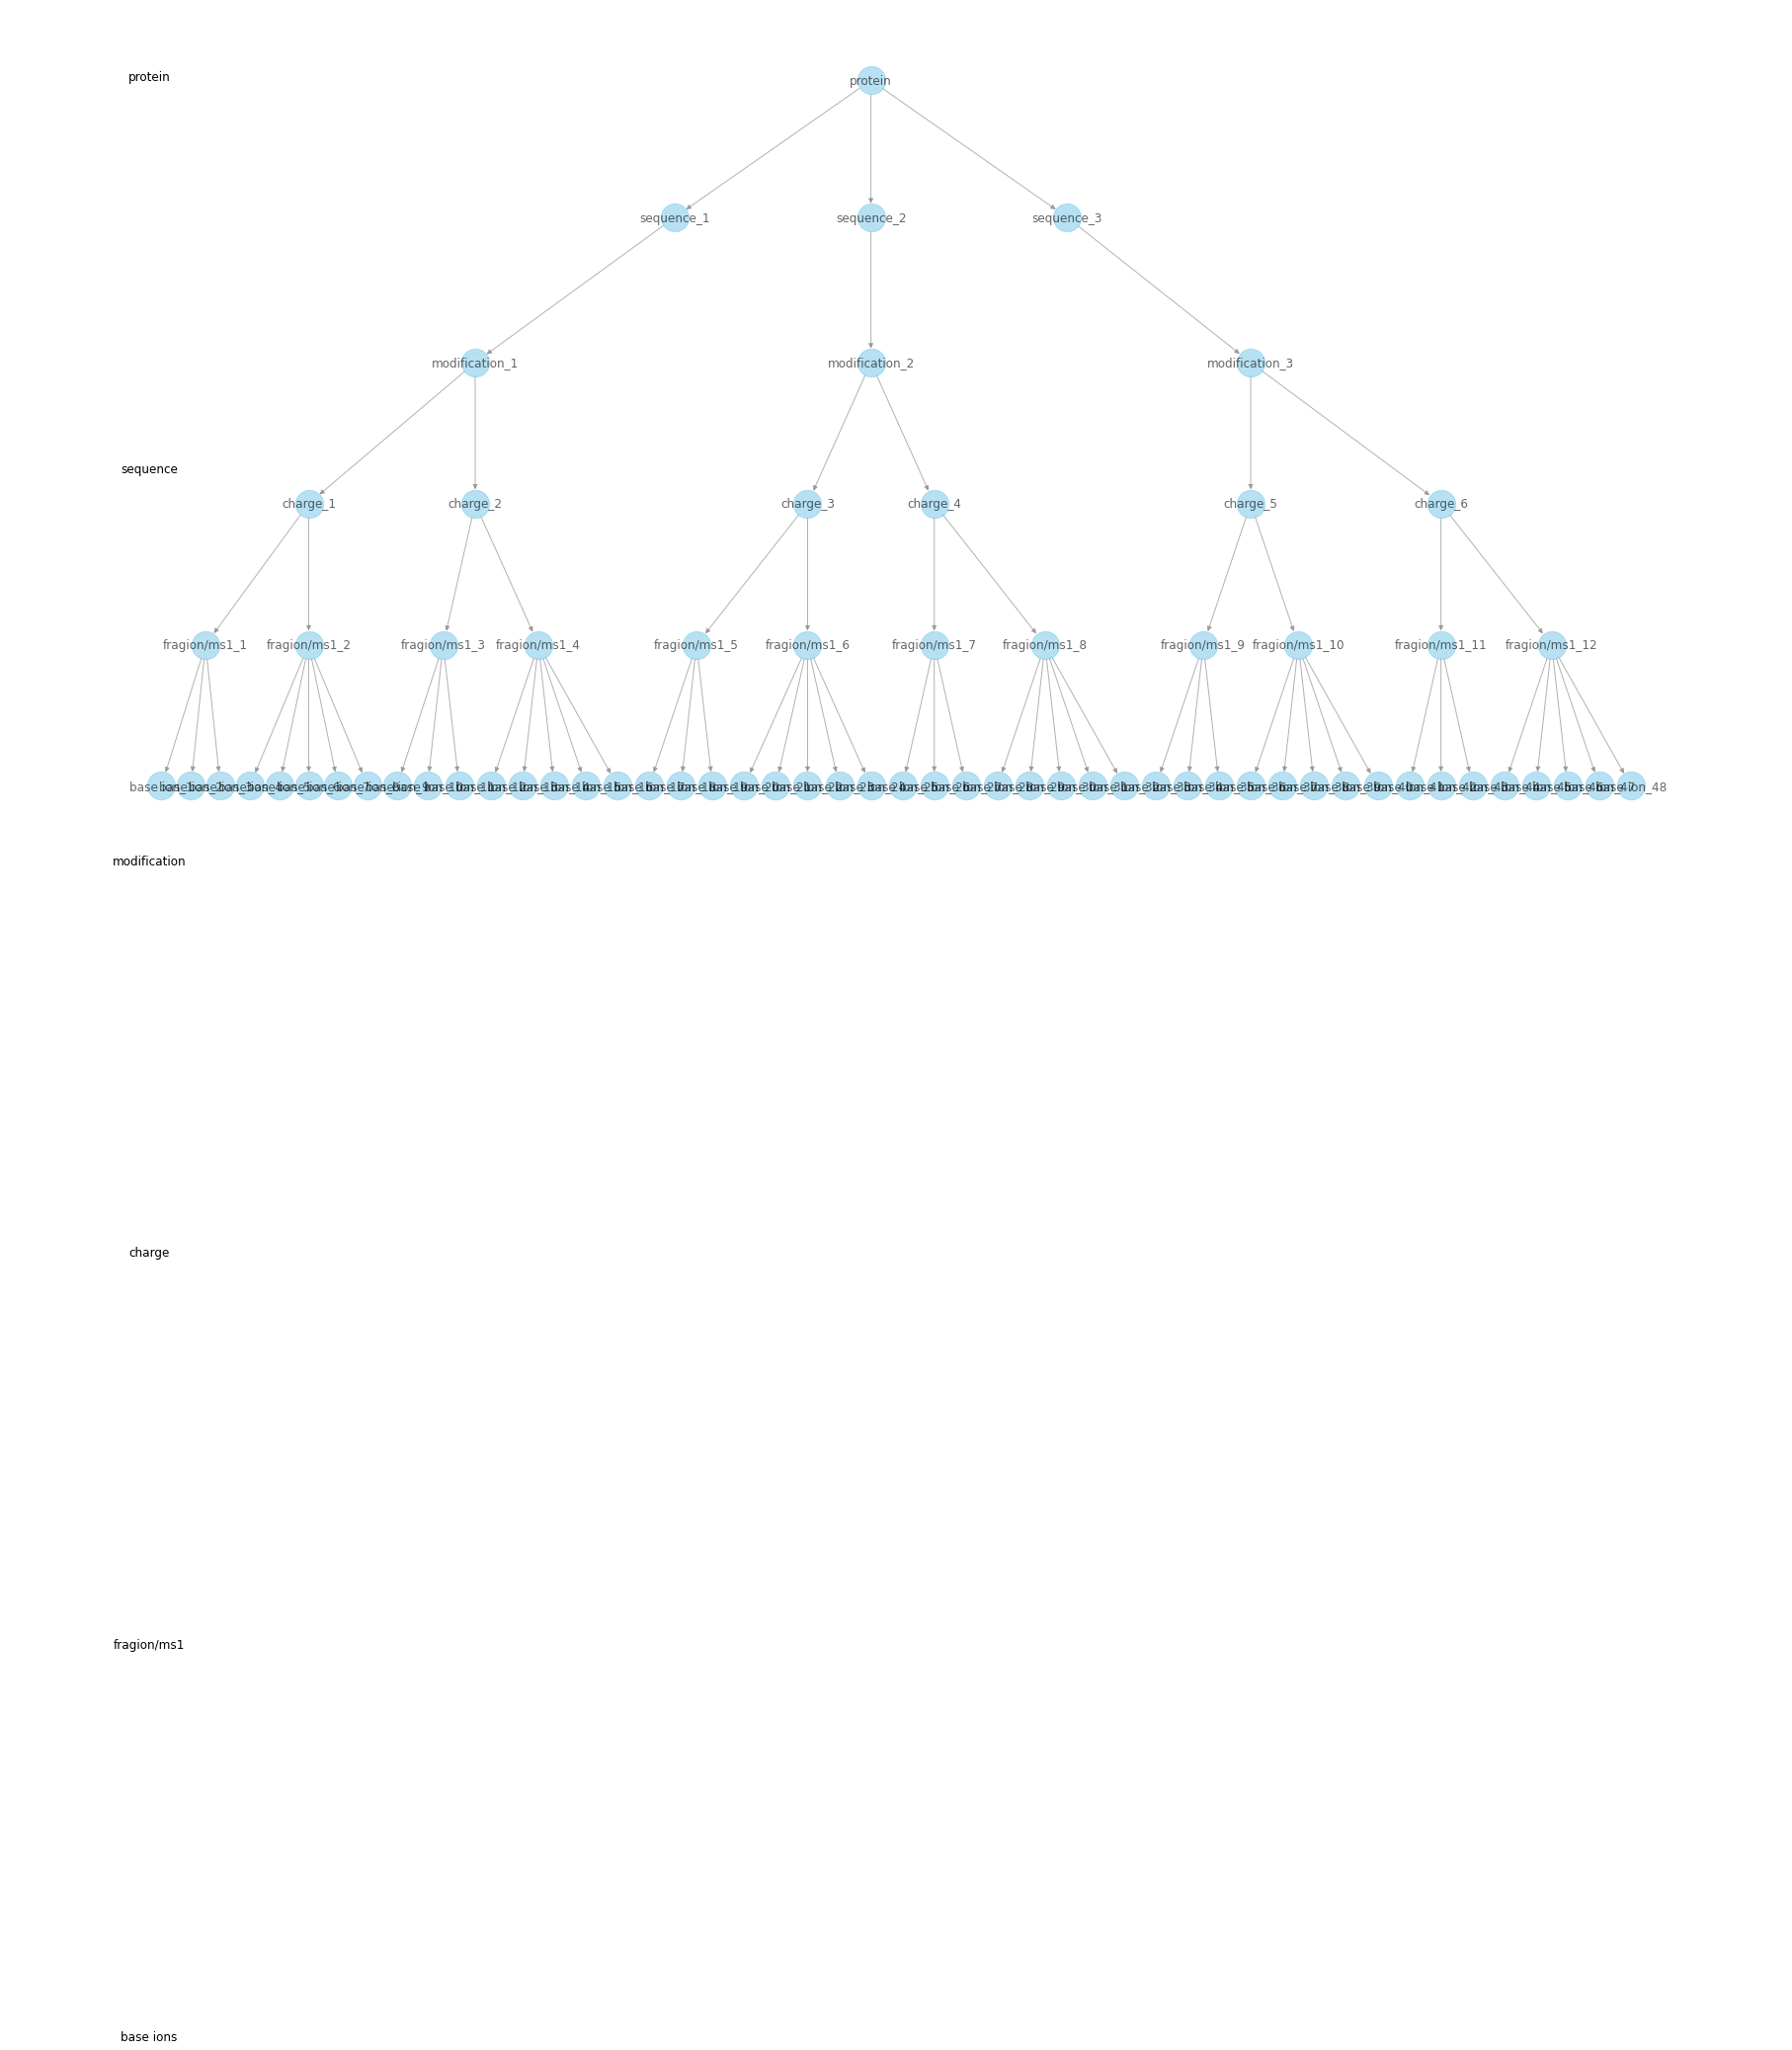

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

def add_sequence_nodes(G, root):
    sequences = []
    for i in range(3):
        seq = f'sequence_{i+1}'
        G.add_edge(root, seq)
        sequences.append(seq)
    return sequences

def add_modification_nodes(G, sequences):
    modifications = []
    for seq in sequences:
        mod = f'modification_{len(modifications) + 1}'
        G.add_edge(seq, mod)
        modifications.append(mod)
    return modifications

def add_charge_nodes(G, modifications):
    charges = []
    for mod in modifications:
        charge_left = f'charge_{len(charges) + 1}'
        charge_right = f'charge_{len(charges) + 2}'
        G.add_edge(mod, charge_left)
        G.add_edge(mod, charge_right)
        charges.extend([charge_left, charge_right])
    return charges

def add_fragion_nodes(G, charges, isotope_counter):
    for ch in charges:
        left_fragion = f'fragion/ms1_{2*charges.index(ch) + 1}'
        right_fragion = f'fragion/ms1_{2*charges.index(ch) + 2}'
        
        G.add_edge(ch, left_fragion)
        isotope_counter = add_isotope_nodes(G, left_fragion, isotope_counter, 3)
        
        G.add_edge(ch, right_fragion)
        isotope_counter = add_isotope_nodes(G, right_fragion, isotope_counter, 5)
        
    return isotope_counter

def add_isotope_nodes(G, parent, start_counter, num):
    for i in range(num):
        isotope = f'base ion_{start_counter + i}'
        G.add_edge(parent, isotope)
    return start_counter + num

def create_tree():
    G = nx.DiGraph()
    root = 'protein'
    
    sequences = add_sequence_nodes(G, root)
    modifications = add_modification_nodes(G, sequences)
    charges = add_charge_nodes(G, modifications)
    add_fragion_nodes(G, charges, 1)

    return G

G = create_tree()

# Use pydot and Graphviz for a hierarchical layout
pos = graphviz_layout(G, prog='dot')

# Custom positioning for the immediate children of the 'protein' node
children_y = list(pos.values())[0][1] - 70  
children_x = [list(pos.values())[0][0] - 800, list(pos.values())[0][0], list(pos.values())[0][0] + 800]
for i, seq in enumerate([f'sequence_{i+1}' for i in range(3)]):
    pos[seq] = (children_x[i], children_y)

# Draw the tree without individual node labels
plt.figure(figsize=(25, 12))  
nx.draw(G, pos, node_size=800, node_color="skyblue", width=1, edge_color="gray", alpha=0.6, with_labels=True)

# Add level names
level_names = ['protein', 'sequence', 'modification', 'charge', 'fragion/ms1', 'base ions']
for level, name in enumerate(level_names):
    plt.text(0, max(y for x, y in pos.values()) - level * 200, name, horizontalalignment='center', fontsize=12)


plt.axis("off")
plt.show()

plt.savefig('tree.pdf', bbox_inches='tight')
